# Causal Impact

## 1. Concepts

The <a href=https://storage.googleapis.com/pub-tools-public-publication-data/pdf/41854.pdf>Causal Impact</a> model developed by Google works by fitting a bayesian structural time series model to observed data which is later used for predicting what the results would be had no intervention happened in a given time period, as depicted below:

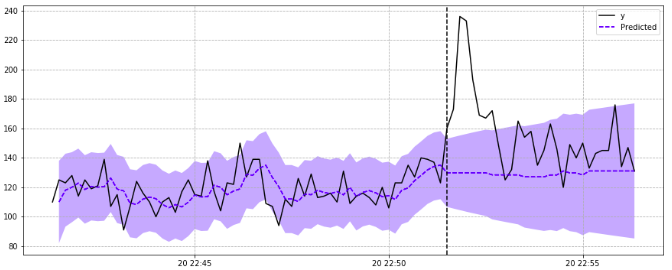

The idea is to used the predictions of the fitted model (depicted in blue) as a reference to what probably would had been observed with no intervention taking place.

Bayesian Structural Time Series models can be expressed by the following equations:

<center>$ y_t = Z^T_t\alpha_t + \beta X_t + G_t\epsilon_t$</center>
<center>$ a_{t+1} = T_t\alpha_t + H_t\eta_t$</center>
<center>$\epsilon_t \sim \mathcal{N}(0, \sigma_t^2)$</center>
<center>$\eta_t \sim \mathcal{N}(0, Q_t)$</center>

The $a$ is also referred as a "state" of the series and $y_t$ is a linear combination of the states plus a linear regression with the covariates $X$ (and the measurement noise $\epsilon$ that follows a zero-mean normal distribution).

By varying the matricex $Z$, $T$, $G$ and $H$ we can model several distinct behaviors for the time series (including the more well known such as ARMA or ARIMA).

In this package (the same is true for Google's R package), you can choose any time series model you want to fit your data (more about this later below). If no model is used as input, a local level is built by default, which means $y_t$ is expressed as:

<center>$ y_t = \mu_t + \gamma_t + \beta X_t + \epsilon_t$</center>
<center>$ \mu_{t+1} = \mu_t +  \eta_{\mu, t}$</center>

Any given point in time is modeled first by a random walk component $\mu_t$, also known as the "local level" component, which increases as the other arguments doesn't add much signal into explaining the data (as it models just randomness, there's no information being added with this component except the expectation for greater uncertainty). 

We then have $\gamma_t$ which models seasonal components. This package uses the same model as the frequency one described in statsmodels:

\begin{split}\gamma_t & =  \sum_{j=1}^h \gamma_{j, t} \\
\gamma_{j, t+1} & = \gamma_{j, t}\cos(\lambda_j)
                + \gamma^{*}_{j, t}\sin(\lambda_j) + \omega_{j,t} \\
\gamma^{*}_{j, t+1} & = -\gamma^{(1)}_{j, t}\sin(\lambda_j)
                    + \gamma^{*}_{j, t}\cos(\lambda_j)
                    + \omega^{*}_{j, t}, \\
\omega^{*}_{j, t}, \omega_{j, t} & \sim N(0, \sigma_{\omega^2}) \\
\lambda_j & = \frac{2 \pi j}{s}\end{split}

Finally we have the component $\beta X_t$ which is a linear regression of covariates that further helps to explain observed data. The better this component works into the prediction task, the lower the local level component should be.

The parameter $\epsilon_t$ models noise related to measuring $y_t$ and it follows a normal distribution with zero mean and $\sigma_{\epsilon}$ standard deviation.

## 2. How to Use

### 2.1 Generating Sample Data

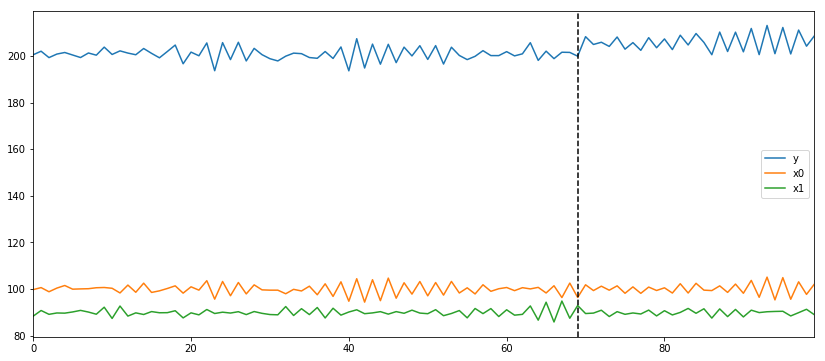

In [5]:
# This is an example presented in Google's R code.
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact


np.random.seed(12345)
ar = np.r_[1, 0.9]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)

x0 = 100 + arma_process.generate_sample(nsample=100)
x1 = 90 + arma_process.generate_sample(nsample=100)
y = 1.2 * x0 + 0.9 * x1 + np.random.normal(size=100)
y[70:] += 5
data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, columns=['y', 'x0', 'x1'])

data.plot()
plt.axvline(69, linestyle='--', color='k')
plt.legend();

### 2.1 Using Default Model

In [6]:
from causalimpact import CausalImpact


pre_period = [0, 69]
post_period = [70, 99]

ci = CausalImpact(data, pre_period, post_period)

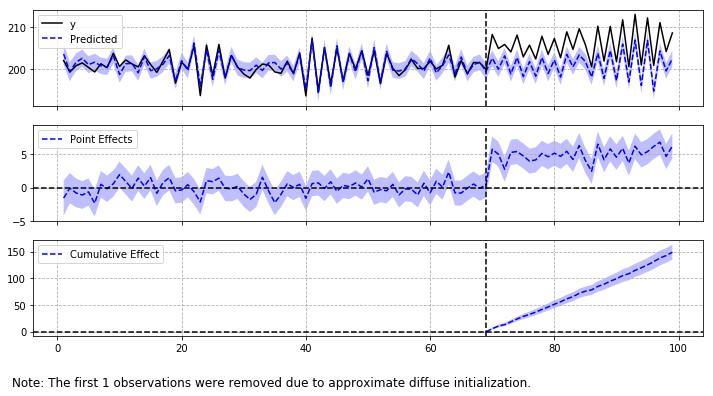

In [8]:
ci.plot(figsize=(12, 6))

When plotting results, three graphics are printed by default:
  - the "origial" series versus its predicted one
  - the "points effects" (which is the difference between original series and predicted)
  - finally the "cumulative" effect which is basically the summation of the point effects accumulated over time.

You can choose which pannels to print; here's an example of just the original series and its point-wise effect printed out:

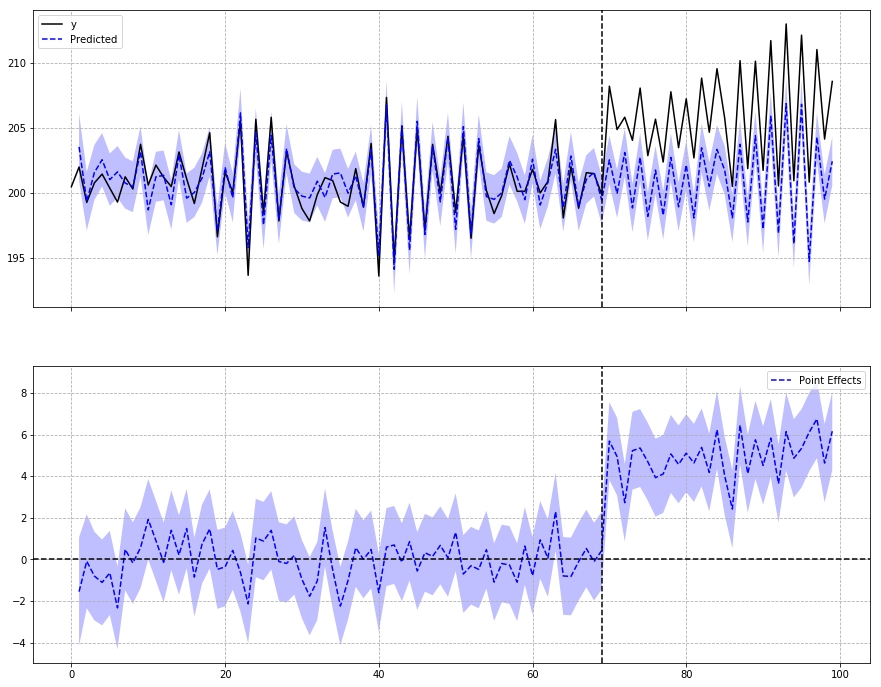

In [13]:
ci.plot(panels=['original', 'pointwise'], figsize=(15, 12))

For also viewing general results and numbers, you can invoke the `summary` method with either default input or "report" which prints a more detailed explanation of the observed effects:

In [14]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    206.0              6179.6
Prediction (s.d.)         201.0 (0.2)        6031.0 (7.3)
95% CI                    [200.6, 201.5]     [6016.5, 6045.0]

Absolute effect (s.d.)    5.0 (0.2)          148.6 (7.3)
95% CI                    [4.5, 5.4]         [134.6, 163.0]

Relative effect (s.d.)    2.5% (0.1%)        2.5% (0.1%)
95% CI                    [2.2%, 2.7%]       [2.2%, 2.7%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


We can see here for instance that the absolute effect observed is of 5.0 whose predictions varies from 4.5 up to 5.4 with 95% confidence interval.

A very important number to also consider when observing these results is the `p-value` or the probability of having a causal effect indeed (and not just noise). Remember to use this value in your analysis before taking conclusions!

If you want a more detailed summary, run the following:

In [15]:
print(ci.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 206.0. By contrast, in the absence of an
intervention, we would have expected an average response of 201.0.
The 95% interval of this counterfactual prediction is [200.6, 201.5].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 5.0 with a 95% interval of
[4.5, 5.4]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 6179.6.
By contrast, had the intervention not taken place, we would have expected
a sum of 6031.0. The 95% interval of this prediction is [6016.5, 6045.0].


The above results are given in terms of absolute numbers. In relative
terms, the response variable sho

The `ci` object also carries all the results of the fitting process, you can access all these values if you want to further analyze results:

In [16]:
ci.inferences.head()

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
0,NaN,199.256404,NaN,NaN,NaN,-5316.556223,5715.069030,NaN,NaN,NaN,1.216337,-5514.596290,5517.028963,NaN,NaN,NaN
1,NaN,203.542200,NaN,NaN,NaN,200.933131,206.151269,NaN,NaN,NaN,-1.552851,-4.161920,1.056218,NaN,NaN,NaN
2,NaN,199.344827,NaN,NaN,NaN,197.085073,201.604581,NaN,NaN,NaN,-0.090130,-2.349884,2.169623,NaN,NaN,NaN
3,NaN,201.573546,NaN,NaN,NaN,199.442809,203.704282,NaN,NaN,NaN,-0.804714,-2.935450,1.326022,NaN,NaN,NaN
4,NaN,202.552743,NaN,NaN,NaN,200.489453,204.616032,NaN,NaN,NaN,-1.108351,-3.171640,0.954939,NaN,NaN,NaN


You can also retrieve information related to the trained model (such as what were the fitted parameters and so on):

In [17]:
ci.trained_model.params

sigma2.irregular    0.111837
sigma2.level        0.000069
beta.x0             0.945247
beta.x1             0.502555
dtype: float64

It's also possible to choose a prior value to the standard deviation of the level parameter (or any parameter you'd like to set boundaries to). Here's an example:

In [13]:
ci = CausalImpact(data, pre_period, post_period, prior_level_sd=0.1)

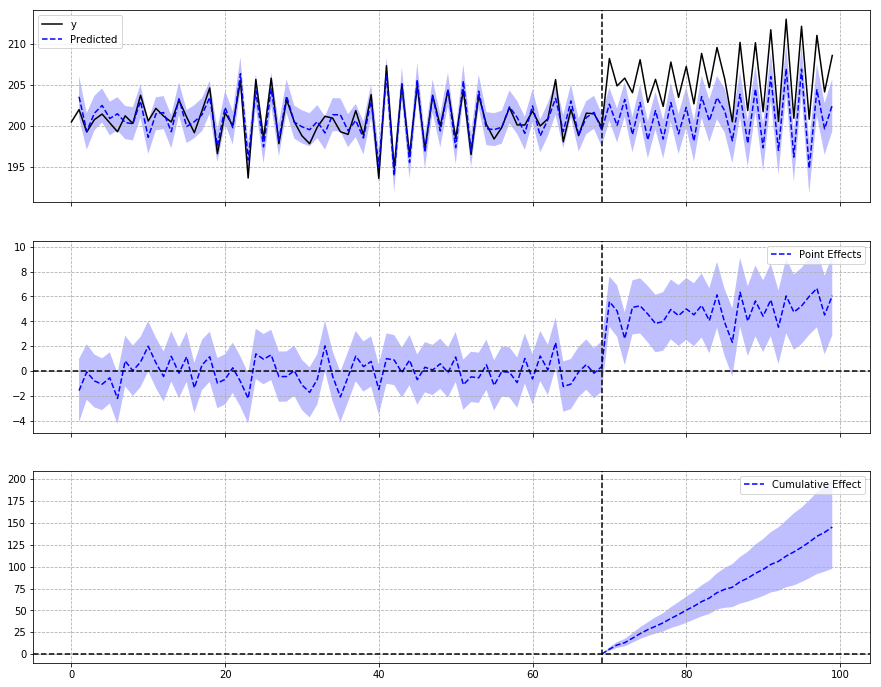

In [19]:
ci.plot(figsize=(15, 12))

Default value is $0.01$ which represents data well behaved with small variance and well explained by the covariates. If it turns out to not to be the case for a given input data, it's possible to change the value on the prior of the local level standard deviation to reflect this pattern in data. For the value $0.1$, we are basically saying that there's a stronger component of a random walk in data that cannot be explained by the covariates themselves.

It's also possible to model season components in data. First, let's use a season simulator available in <a href=https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/statespace_seasonal.ipynb>statsmodels package</a>:

In [15]:
def simulate_seasonal_term(periodicity, total_cycles, noise_std=1.,
                           harmonics=None):
    duration = periodicity * total_cycles
    assert duration == int(duration)
    duration = int(duration)
    harmonics = harmonics if harmonics else int(np.floor(periodicity / 2))

    lambda_p = 2 * np.pi / float(periodicity)

    gamma_jt = noise_std * np.random.randn((harmonics))
    gamma_star_jt = noise_std * np.random.randn((harmonics))

    total_timesteps = 100 * duration # Pad for burn in
    series = np.zeros(total_timesteps) 
    for t in range(total_timesteps):
        gamma_jtp1 = np.zeros_like(gamma_jt)
        gamma_star_jtp1 = np.zeros_like(gamma_star_jt)
        for j in range(1, harmonics + 1):
            cos_j = np.cos(lambda_p * j)
            sin_j = np.sin(lambda_p * j)
            gamma_jtp1[j - 1] = (gamma_jt[j - 1] * cos_j
                                 + gamma_star_jt[j - 1] * sin_j
                                 + noise_std * np.random.randn())
            gamma_star_jtp1[j - 1] = (- gamma_jt[j - 1] * sin_j
                                      + gamma_star_jt[j - 1] * cos_j
                                      + noise_std * np.random.randn())
        series[t] = np.sum(gamma_jtp1)
        gamma_jt = gamma_jtp1
        gamma_star_jt = gamma_star_jtp1
    wanted_series = series[-duration:] # Discard burn in

    return wanted_series

In [16]:
duration = 100
periodicities = [7, 30]
num_harmonics = [2, 5]
std = np.array([0.1, 0.1])
# np.random.seed(8678309)

terms = []
for ix, _ in enumerate(periodicities):
    s = simulate_seasonal_term(
        periodicities[ix],
        duration / periodicities[ix],
        harmonics=num_harmonics[ix],
        noise_std=std[ix])
    terms.append(s)
terms.append(np.ones_like(terms[0]) * 10.)
seasons = pd.Series(np.sum(terms, axis=0))

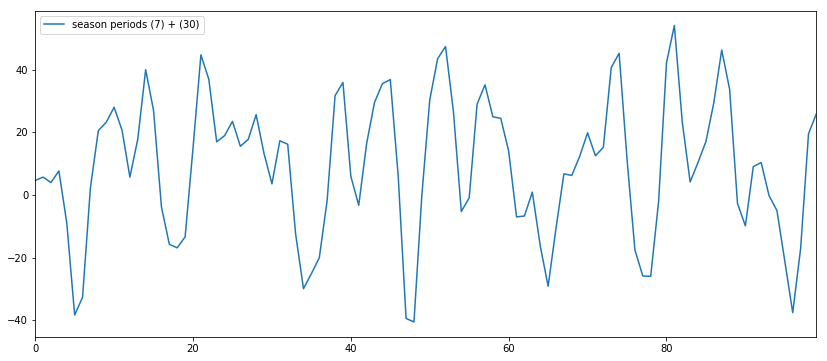

In [17]:
seasons.plot(label='season periods (7) + (30)', legend=True);

In [18]:
season_data = data.copy()
season_data['y'] += seasons

In [19]:
ci = CausalImpact(season_data, pre_period, post_period,
                  nseasons=[{'period': 7, 'harmonics': 2}, {'period': 30, 'harmonics': 5}])

In [25]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    216.1              6484.3
Prediction (s.d.)         211.2 (0.9)        6335.2 (25.7)
95% CI                    [209.5, 212.9]     [6284.7, 6385.6]

Absolute effect (s.d.)    5.0 (0.9)          149.1 (25.7)
95% CI                    [3.3, 6.7]         [98.7, 199.6]

Relative effect (s.d.)    2.4% (0.4%)        2.4% (0.4%)
95% CI                    [1.6%, 3.1%]       [1.6%, 3.1%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


### 2.2 Working with Dates Index

The model should work with dates as well. Let's see what happens when our input data have a date as index type:

In [21]:
dated_data = data.set_index(pd.date_range(start='20180101', periods=len(data)))

pre_period = ['20180101', '20180311']
post_period = ['20180312', '20180410']

figsize = (20, 6)
ci = CausalImpact(dated_data, pre_period, post_period)

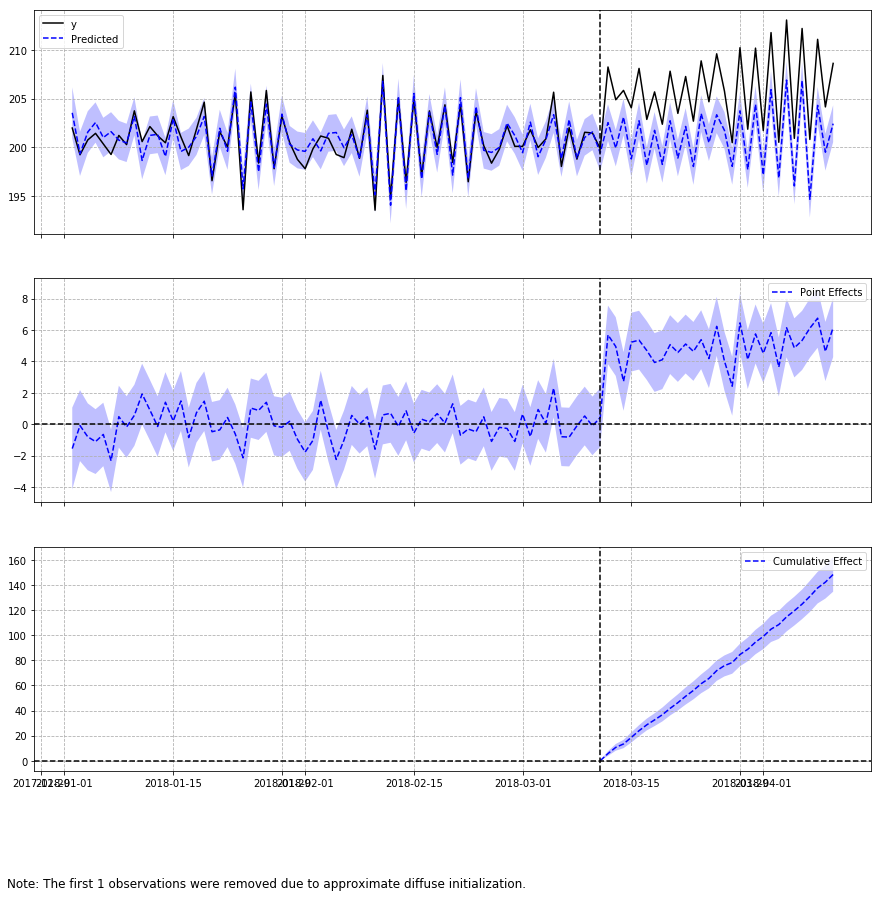

In [22]:
ci.plot(figsize=(15, 14))

In [28]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    206.0              6179.6
Prediction (s.d.)         201.0 (0.2)        6031.0 (7.0)
95% CI                    [200.6, 201.5]     [6017.2, 6044.8]

Absolute effect (s.d.)    5.0 (0.2)          148.6 (7.0)
95% CI                    [4.5, 5.4]         [134.8, 162.3]

Relative effect (s.d.)    2.5% (0.1%)        2.5% (0.1%)
95% CI                    [2.2%, 2.7%]       [2.2%, 2.7%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


### 2.3 Customized Model

Just as in Google R package, here you can also choose a customized model to be trained in the pre-intervention period. It's important to note that if you want to have the data standardized, then your customized model must be built with data already standardized and the input `data` must be the original denormalized data, like so:

In [24]:
from causalimpact.misc import standardize

normed_pre_data, _ = standardize(data.iloc[:70])

model = UnobservedComponents(
    endog=normed_pre_data.iloc[:70, 0],
    level='llevel',
    exog=normed_pre_data.iloc[:70, 1:]
)

pre_period = [0, 69]
post_period = [70, 99]

ci = CausalImpact(data, pre_period, post_period, model=model)

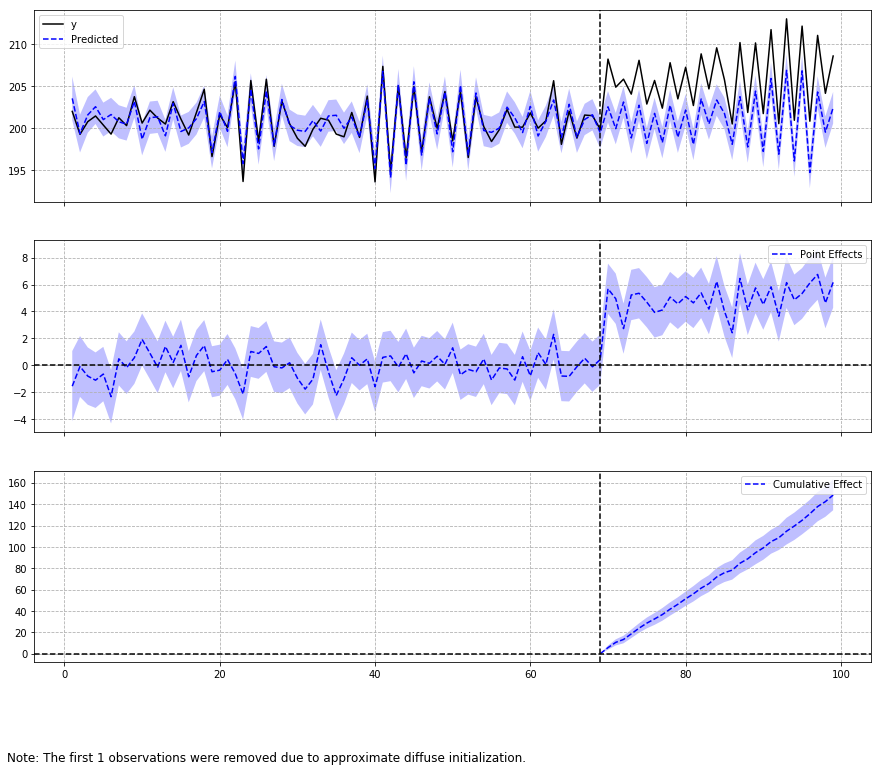

In [25]:
ci.plot(figsize=(15, 12))

In [26]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    206.0              6179.6
Prediction (s.d.)         201.0 (0.2)        6031.0 (7.4)
95% CI                    [200.5, 201.5]     [6016.3, 6045.2]

Absolute effect (s.d.)    5.0 (0.2)          148.6 (7.4)
95% CI                    [4.5, 5.4]         [134.4, 163.3]

Relative effect (s.d.)    2.5% (0.1%)        2.5% (0.1%)
95% CI                    [2.2%, 2.7%]       [2.2%, 2.7%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


In [27]:
ci.trained_model.params

sigma2.irregular    0.111837
sigma2.level        0.000069
beta.x0             0.945247
beta.x1             0.502555
dtype: float64

### 2.5 Understanding Results

While this is a more sophisticated approach into understanding results from the model, you can print out metrics of the trained model to see why it has fitted the way it has:

In [33]:
dated_data = data.set_index(pd.date_range(start='20180101', periods=len(data)))

pre_period = ['20180101', '20180311']
post_period = ['20180312', '20180410']

ci = CausalImpact(dated_data, pre_period, post_period)

Remember that the local level model is built by using a noise $\epsilon$, a random walk (level) and the linear regression (beta.X). Sometimes you'll want to see what the values for beta.X are: in case it's too small, then probably the covariate you used in your model is not helping much to explain $y_t$ and you may consider its usefulness into helping to explain the data.

In [34]:
ci.trained_model.params

sigma2.irregular    0.111837
sigma2.level        0.000069
beta.x0             0.945247
beta.x1             0.502555
dtype: float64

As we can see, the beta.X helps to explain a lot of what is observed in the response variable. Let's see what happens when we add a total random variable as a covariate to our data:

In [35]:
x2 = pd.DataFrame(np.random.randn(100, 1), columns=['x2'])
data2 = pd.concat([data, x2], axis=1)

In [36]:
pre_period = [0, 69]
post_period = [70, 99]
ci = CausalImpact(data2, pre_period, post_period)

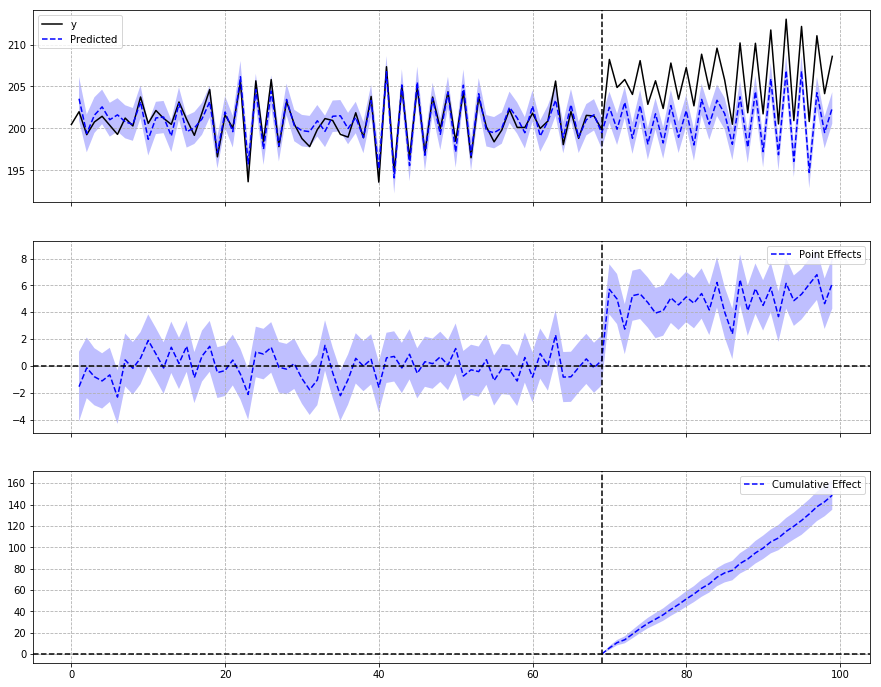

In [37]:
ci.plot(figsize=(15, 12))

In [38]:
ci.trained_model.params

sigma2.irregular    0.111778
sigma2.level        0.000069
beta.x0             0.944608
beta.x1             0.503352
beta.x2            -0.007619
dtype: float64

$\beta_{x_2}$ doesn't help to explain $y_t$ as we'd expect from a complete random variable with no relationship with the observed data.

Here's now one example with real data:

In [39]:
gdata = pd.read_csv('../tests/fixtures/google_data.csv')
gdata.index = pd.to_datetime(gdata['t'])
del gdata['t']

In [40]:
pre_period = ['2016-02-20 22:41:20', '2016-02-20 22:51:20']
post_period = ['2016-02-20 22:51:30', '2016-02-20 22:56:20']

ci = CausalImpact(gdata, pre_period, post_period)

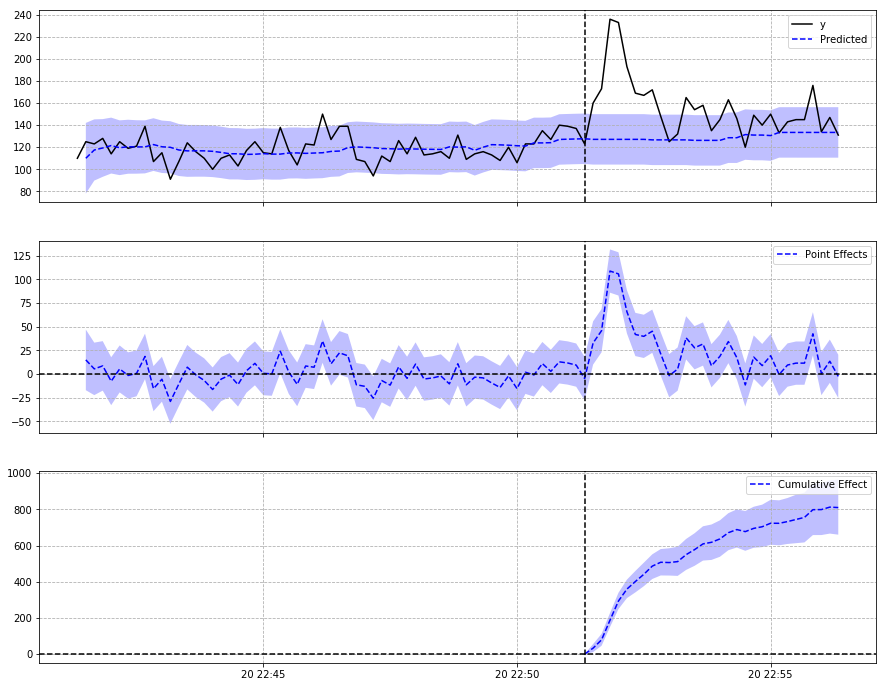

In [41]:
ci.plot(figsize=(15, 12))

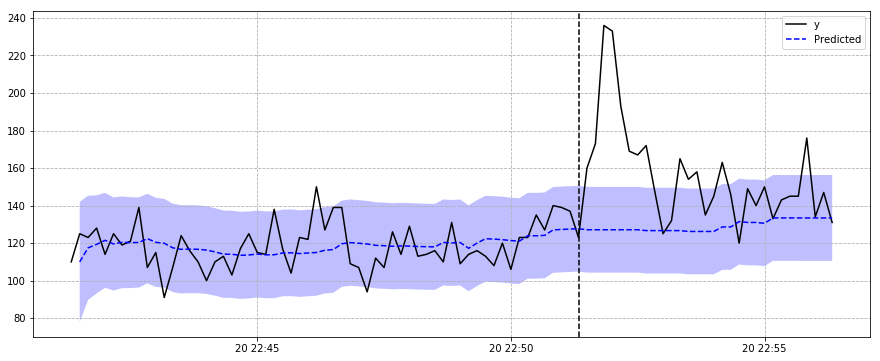

In [42]:
ci.plot(figsize=(15, 6), panels=['original'])

In [43]:
ci.trained_model.params

sigma2.irregular    0.940607
sigma2.level        0.000069
beta.x1             0.134246
beta.x2            -0.371246
dtype: float64

In [44]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    156.2              4687.0
Prediction (s.d.)         129.2 (2.6)        3876.8 (77.6)
95% CI                    [124.1, 134.2]     [3722.5, 4026.7]

Absolute effect (s.d.)    27.0 (2.6)         810.2 (77.6)
95% CI                    [22.0, 32.1]       [660.3, 964.5]

Relative effect (s.d.)    20.9% (2.0%)       20.9% (2.0%)
95% CI                    [17.0%, 24.9%]     [17.0%, 24.9%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


The example above is a good one for seeing the effects that setting a prior knowledge on the local level parameter has in final results. If we let the optimizer find the value automatically, here's what we find:

In [45]:
ci = CausalImpact(gdata, pre_period, post_period, prior_level_sd=None)

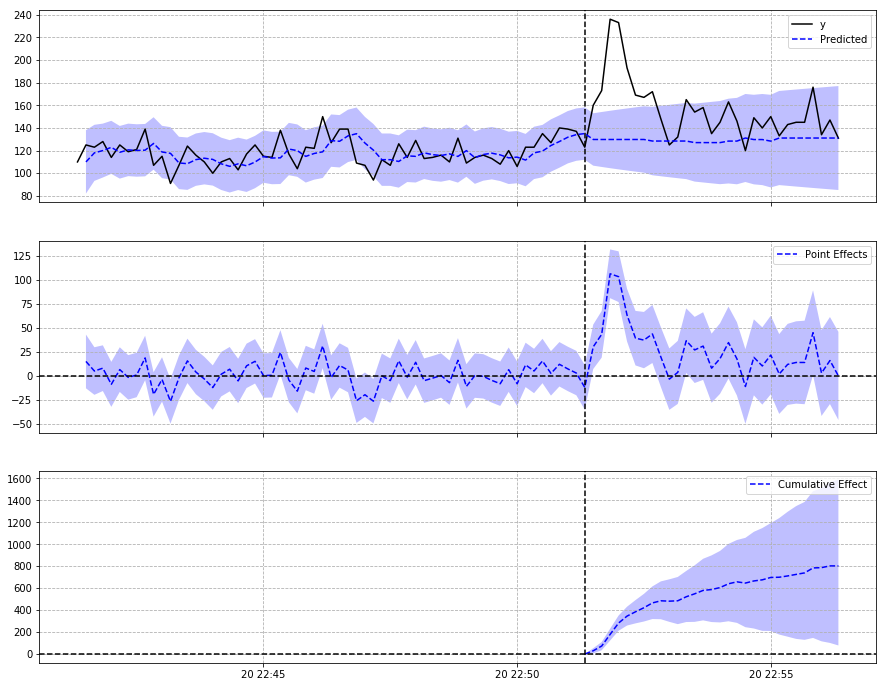

In [46]:
ci.plot(figsize=(15, 12))

In [47]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    156.2              4687.0
Prediction (s.d.)         129.5 (12.8)       3883.9 (385.2)
95% CI                    [103.3, 153.6]     [3098.5, 4608.5]

Absolute effect (s.d.)    26.8 (12.8)        803.1 (385.2)
95% CI                    [2.6, 53.0]        [78.5, 1588.5]

Relative effect (s.d.)    20.7% (9.9%)       20.7% (9.9%)
95% CI                    [2.0%, 40.9%]      [2.0%, 40.9%]

Posterior tail-area probability p: 0.018
Posterior prob. of a causal effect: 98.20%

For more details run the command: print(impact.summary('report'))


In [48]:
ci.trained_model.params

sigma2.irregular    0.667721
sigma2.level        0.099363
beta.x1             0.405506
beta.x2            -0.353930
dtype: float64

As shown above, the level variance ends up being a bit higher which results in much wider confidence intervals than before.

### 2.6 More Real Data Example

(this section is inspired in the issue <a href=https://github.com/dafiti/causalimpact/issues/31>31</a> created by user **mg515**)

In this section, we'll be working with stock values of three big companies, VolksWagen, BMW And Allianz in order to find what the consequences were for VW after the <a href=https://en.wikipedia.org/wiki/Volkswagen_emissions_scandal>emissions scandal</a> of September 2015 took place.

To beging with, let's load the data:

### 2.7 TODO's

- Still need to investigate how useful computing the bayesian regret it would be for final summary.

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.arima_process import ArmaProcess
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
figsize(14, 6)

In [3]:
from IPython.core.display import HTML


def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()